In [98]:
from flipside import Flipside
import pandas as pd
import numpy as np
import requests
import json
import warnings
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
warnings.filterwarnings('ignore')

In [99]:
balance_sheet_sql = """
WITH RECURSIVE date_series AS (
  SELECT '2023-03-22'::DATE AS day
  UNION ALL
  SELECT day + 1
  FROM date_series
  WHERE day + 1 <= CURRENT_DATE
),
eth_price_daily AS (
    SELECT 
        date_trunc('day', HOUR) AS day, 
        AVG(price) AS avg_price
    FROM ethereum.price.ez_hourly_token_prices
    WHERE symbol = 'WETH'
    GROUP BY date_trunc('day', HOUR)
),
balance_data AS (
    SELECT
        date_trunc('day', block_timestamp) AS day,
        block_timestamp,
        current_bal
    FROM ethereum.core.ez_balance_deltas
    WHERE user_address = lower('0xf1dA938Cbf912b9e5444F6532C20A58d09Dd67B8')
),
filled_balances AS (
    SELECT
        ds.day AS day,
        COALESCE(
            bd.current_bal, 
            LAST_VALUE(bd.current_bal IGNORE NULLS) OVER (
                ORDER BY ds.day ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
            )
        ) AS filled_balance,
        ROW_NUMBER() OVER (PARTITION BY ds.day ORDER BY bd.block_timestamp DESC) AS rn
    FROM date_series ds
    LEFT JOIN balance_data bd ON ds.day = bd.day
),
assets AS (
    SELECT 
        fb.day, 
        fb.filled_balance * ep.avg_price AS balance_in_usd
    FROM filled_balances fb
    LEFT JOIN eth_price_daily ep ON fb.day = ep.day
    WHERE fb.rn = 1
),
equity_sales AS (
    SELECT
        date_trunc('day', block_timestamp) AS day,
        ethereum.public.udf_hex_to_int(SUBSTR(DATA, 1, 66)) AS ID,
        ethereum.public.udf_hex_to_int(substr(data, 131, 64)) / power(10, 18) AS amount_eth
    FROM ethereum.core.fact_event_logs
    WHERE contract_address = lower('0x93519f3558775BBd5c0d501A2fD7a58bb034B379') AND
              topics[0] = lower('0xc9f72b276a388619c6d185d146697036241880c36654b1a3ffdad07c24038d99')
),
daily_data AS (
    SELECT
        ds.day,
        COALESCE(es.transaction_value_eth, 0) AS transaction_value_eth,
        COALESCE(es.unique_units, 0) AS unique_units
    FROM date_series ds
    LEFT JOIN (
        SELECT 
            day,
            SUM(amount_eth) AS transaction_value_eth,
            COUNT(DISTINCT ID) AS unique_units
        FROM equity_sales
        GROUP BY day
    ) es ON ds.day = es.day
),
rolling_avg_price AS (
    SELECT
        day,
        AVG(transaction_value_eth / NULLIF(unique_units, 0)) OVER (ORDER BY day ROWS BETWEEN 29 PRECEDING AND CURRENT ROW) AS avg_price_last_30_days
    FROM daily_data
),
cumulative_units AS (
    SELECT
        day,
        SUM(unique_units) OVER (ORDER BY day) AS cumulative_units
    FROM daily_data
),
market_cap AS (
    SELECT
        rap.day,
        COALESCE(
            rap.avg_price_last_30_days * ep.avg_price,
            LAST_VALUE(rap.avg_price_last_30_days * ep.avg_price IGNORE NULLS) OVER (
                ORDER BY rap.day ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
            )
        ) AS avg_price_last_30_days_usd,
        cu.cumulative_units,
        -1 * COALESCE(
            rap.avg_price_last_30_days * cu.cumulative_units * ep.avg_price,
            LAST_VALUE(rap.avg_price_last_30_days * cu.cumulative_units * ep.avg_price IGNORE NULLS) OVER (
                ORDER BY rap.day ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
            )
        ) AS market_capitalization_usd
    FROM rolling_avg_price rap
    LEFT JOIN eth_price_daily ep ON rap.day = ep.day
    JOIN cumulative_units cu ON rap.day = cu.day
)

SELECT 
    a.day, 
    a.balance_in_usd as assets, 
    mc.avg_price_last_30_days_usd, 
    mc.cumulative_units, 
    mc.market_capitalization_usd as equity,
    -mc.market_capitalization_usd as market_cap 
FROM assets a
JOIN market_cap mc ON a.day = mc.day
ORDER BY a.day desc;


"""

In [100]:
income_statement_sql = """

WITH auctions AS (
    SELECT
        date_trunc('Month', BLOCK_TIMESTAMP) AS month,
        SUM(ethereum.public.udf_hex_to_int(substr(data, 131, 64)) / power(10, 18)) AS auction_revenue_eth
    FROM ethereum.core.fact_event_logs
    WHERE contract_address = lower('0x93519f3558775BBd5c0d501A2fD7a58bb034B379') AND
          topics[0] = lower('0xc9f72b276a388619c6d185d146697036241880c36654b1a3ffdad07c24038d99')
    GROUP BY date_trunc('Month', BLOCK_TIMESTAMP)
),
seed_funding AS (
    SELECT 
        date_trunc('Month', BLOCK_TIMESTAMP) AS month, 
        SUM(ETH_VALUE) AS eth_value
    FROM ethereum.core.fact_traces
    WHERE TO_ADDRESS = lower('0xf1dA938Cbf912b9e5444F6532C20A58d09Dd67B8')
    GROUP BY date_trunc('Month', BLOCK_TIMESTAMP)
),
eth_price AS (
    SELECT 
        date_trunc('Month', HOUR) AS month, 
        avg(price) AS avg_price
    FROM ethereum.price.ez_hourly_token_prices
    WHERE symbol = 'WETH'
    GROUP BY date_trunc('Month', HOUR)
),
combined_revenue AS (
    SELECT
        sf.month,
        sf.eth_value AS total_revenue_eth,
        a.auction_revenue_eth,
        (sf.eth_value - COALESCE(a.auction_revenue_eth, 0)) AS non_auction_revenue_eth,
        sf.eth_value * ep.avg_price AS total_revenue_usd,
        COALESCE(a.auction_revenue_eth, 0) * ep.avg_price AS auction_revenue_usd,
        (sf.eth_value - COALESCE(a.auction_revenue_eth, 0)) * ep.avg_price AS non_auction_revenue_usd
    FROM seed_funding sf
    LEFT JOIN auctions a ON sf.month = a.month
    LEFT JOIN eth_price ep ON sf.month = ep.month
),
expenses AS (
    SELECT 
        date_trunc('Month', BLOCK_TIMESTAMP) AS month, 
        -SUM(ethereum.public.udf_hex_to_int(substr(data, 451, 64)) / power(10, 18)) AS expenses_eth
    FROM ethereum.core.fact_event_logs
    WHERE contract_address = lower('0xf1dA938Cbf912b9e5444F6532C20A58d09Dd67B8') AND
          topics[0] = lower('0x7e74d8579043af873f575ed17043a48d6beba2668c6b53325bcd8c9a550e5e9c')
    GROUP BY date_trunc('Month', BLOCK_TIMESTAMP)
),
monthly_expenses AS (
    SELECT 
        e.month,
        e.expenses_eth,
        e.expenses_eth * ep.avg_price AS expenses_usd
    FROM expenses e
    LEFT JOIN eth_price ep ON e.month = ep.month
)
SELECT
    cr.month,
    cr.total_revenue_eth,
    cr.auction_revenue_eth,
    cr.non_auction_revenue_eth,
    cr.total_revenue_usd,
    cr.auction_revenue_usd,
    cr.non_auction_revenue_usd,
    COALESCE(me.expenses_eth, 0) AS expenses_eth,
    COALESCE(me.expenses_usd, 0) AS expenses_usd,
    COALESCE(cr.total_revenue_eth, 0) + COALESCE(me.expenses_eth, 0) AS net_income_eth,
    COALESCE(cr.total_revenue_usd, 0) + COALESCE(me.expenses_usd, 0) AS net_income_usd
FROM combined_revenue cr
FULL OUTER JOIN monthly_expenses me ON cr.month = me.month
ORDER BY cr.month DESC;


"""

In [101]:
api_key = '4604d4d2-ccf3-4864-90b4-db6bf13c663b'
api_key_cg = 'CG-jTsiV2rsyVSHHULoNSWHU493'

In [102]:
def createQueryRun(sql):
    url = "https://api-v2.flipsidecrypto.xyz/json-rpc"

    payload = json.dumps({
      "jsonrpc": "2.0",
      "method": "createQueryRun",
      "params": [
        {
          "resultTTLHours": 1,
          "maxAgeMinutes": 0,
          "sql": sql,
          "tags": {
            "source": "postman-demo",
            "env": "test"
          },
          "dataSource": "snowflake-default",
          "dataProvider": "flipside"
        }
      ],
      "id": 1
    })
    headers = {
      'Content-Type': 'application/json',
      'x-api-key': api_key
    }
    
    response = requests.request("POST", url, headers=headers, data=payload)
    response_data = json.loads(response.text)
    query_run_id = response_data['result']['queryRun']['id']
    #total_pages = response_data['result']['queryRun']['totalSize']
    
    return response_data, query_run_id#, total_pages, 
     

    if 'error' in response_data:
        print("Error:", response_data['error']['msg'])
    else:
        print("Query Run ID:", query_run_id)


In [103]:
def getQueryResults(query_run_id):#, size):
    url = "https://api-v2.flipsidecrypto.xyz/json-rpc"

    payload = json.dumps({
      "jsonrpc": "2.0",
      "method": "getQueryRunResults",
      "params": [
        {
          "queryRunId": query_run_id,
          "format": "json",
          "page": {
            "number": 1,
            "size": 100000000000000
          }
        }
      ],
      "id": 1
    })
    headers = {
      'Content-Type': 'application/json',
      'x-api-key': api_key
    }
    
    response = requests.request("POST", url, headers=headers, data=payload)
    resp_json = response.json()
    #response_df = pd.DataFrame(resp_json['result']['rows'])
    return resp_json


In [104]:
bs_response_data, q_id = createQueryRun(balance_sheet_sql)


In [105]:
print(bs_response_data['result']['queryRun'])

{'id': 'clsq9vj8l2gqzms0xsw8zp11d', 'sqlStatementId': 'clrx0oz7k00xbol0xnmnf1b1n', 'state': 'QUERY_STATE_READY', 'path': '2024/02/17/16/clsq9vj8l2gqzms0xsw8zp11d', 'fileCount': None, 'lastFileNumber': None, 'fileNames': None, 'errorName': None, 'errorMessage': None, 'errorData': None, 'dataSourceQueryId': None, 'dataSourceSessionId': None, 'startedAt': None, 'queryRunningEndedAt': None, 'queryStreamingEndedAt': None, 'endedAt': None, 'rowCount': None, 'totalSize': None, 'tags': {'env': 'test', 'source': 'postman-demo'}, 'dataSourceId': 'clf90gwee0002jvbu63diaa8u', 'userId': 'clshxidaa1zpan30x0g457n12', 'createdAt': '2024-02-17T16:07:40.000Z', 'updatedAt': '2024-02-17T16:07:40.000Z', 'archivedAt': None, 'rowsPerResultSet': 20000000, 'statementTimeoutSeconds': 900, 'abortDetachedQuery': True}


In [115]:
#bs_resp_d, bs_query_run_id = createQueryRun(balance_sheet_sql)
bs_df = getQueryResults(q_id)

In [116]:
bs_df

{'jsonrpc': '2.0',
 'id': 1,
 'result': {'columnNames': ['day',
   'assets',
   'avg_price_last_30_days_usd',
   'cumulative_units',
   'equity',
   'market_cap',
   '__row_index'],
  'columnTypes': ['date',
   'number',
   'number',
   'number',
   'number',
   'number',
   'number'],
  'rows': [{'day': '2024-02-17T00:00:00.000Z',
    'assets': 30419.115344014,
    'avg_price_last_30_days_usd': 24.507603004,
    'cumulative_units': 74,
    'equity': -1813.562622294,
    'market_cap': 1813.562622294,
    '__row_index': 0},
   {'day': '2024-02-16T00:00:00.000Z',
    'assets': 30677.2736494,
    'avg_price_last_30_days_usd': 24.715592,
    'cumulative_units': 74,
    'equity': -1828.953808,
    'market_cap': 1828.953808,
    '__row_index': 1},
   {'day': '2024-02-15T00:00:00.000Z',
    'assets': 30545.1900996,
    'avg_price_last_30_days_usd': 24.25852,
    'cumulative_units': 73,
    'equity': -1770.87196,
    'market_cap': 1770.87196,
    '__row_index': 2},
   {'day': '2024-02-14T00:00

In [117]:
bs_dataframe = pd.DataFrame(bs_df['result']['rows'])


In [118]:
bs_dataframe['day'] = pd.to_datetime(bs_dataframe['day'])
bs_dataframe.set_index('day', inplace=True)
bs_dataframe

,assets,avg_price_last_30_days_usd,cumulative_units,equity,market_cap,__row_index
day,,,,,,
2024-02-17 00:00:00+00:00,30419.115344,24.507603,74,-1813.562622,1813.562622,0
2024-02-16 00:00:00+00:00,30677.273649,24.715592,74,-1828.953808,1828.953808,1
2024-02-15 00:00:00+00:00,30545.190100,24.258520,73,-1770.871960,1770.871960,2
2024-02-14 00:00:00+00:00,29523.124005,23.446811,73,-1711.617191,1711.617191,3
2024-02-13 00:00:00+00:00,28859.561526,22.919820,73,-1673.146840,1673.146840,4
...,...,...,...,...,...,...
2023-03-26 00:00:00+00:00,791.322610,197.830653,4,-791.322610,791.322610,328
2023-03-25 00:00:00+00:00,768.223422,256.074474,3,-768.223422,768.223422,329
2023-03-24 00:00:00+00:00,782.656985,260.885662,3,-782.656985,782.656985,330


In [119]:
is_response, is_query_run_id= createQueryRun(income_statement_sql)


In [124]:
is_df = getQueryResults(is_query_run_id)


In [125]:
is_dataframe = pd.DataFrame(is_df['result']['rows'])
is_dataframe['month'] = pd.to_datetime(is_dataframe['month'])
is_dataframe.set_index('month', inplace=True)

In [126]:
is_dataframe

,total_revenue_eth,auction_revenue_eth,non_auction_revenue_eth,total_revenue_usd,auction_revenue_usd,non_auction_revenue_usd,expenses_eth,expenses_usd,net_income_eth,net_income_usd,__row_index
month,,,,,,,,,,,
2024-02-01 00:00:00+00:00,0.02000,0.02000,0.000000e+00,49.712565,49.712565,0.000000e+00,-3.96,-9843.087819,-3.94000,-9793.375255,0
2024-01-01 00:00:00+00:00,0.06800,0.06800,0.000000e+00,161.244300,161.244300,0.000000e+00,0.00,0.000000,0.06800,161.244300,1
2023-12-01 00:00:00+00:00,0.00000,NaN,0.000000e+00,0.000000,0.000000,0.000000e+00,-1.24,-2794.853873,-1.24000,-2794.853873,2
2023-10-01 00:00:00+00:00,0.05100,0.05100,0.000000e+00,84.453608,84.453608,0.000000e+00,-0.66,-1092.929049,-0.60900,-1008.475441,3
2023-09-01 00:00:00+00:00,0.02000,0.02000,0.000000e+00,32.419436,32.419436,0.000000e+00,0.00,0.000000,0.02000,32.419436,4
2023-08-01 00:00:00+00:00,0.26356,0.26356,-5.551115e-17,463.757264,463.757264,-9.767681e-14,-0.35,-615.856133,-0.08644,-152.098869,5
2023-07-01 00:00:00+00:00,1.04700,0.06700,9.800000e-01,1984.660337,127.003097,1.857657e+03,-6.00,-11373.411674,-4.95300,-9388.751337,6
2023-06-01 00:00:00+00:00,0.61630,0.11630,5.000000e-01,1120.464908,211.439346,9.090256e+02,0.00,0.000000,0.61630,1120.464908,7
2023-05-01 00:00:00+00:00,0.19020,0.19020,0.000000e+00,350.509119,350.509119,0.000000e+00,0.00,0.000000,0.19020,350.509119,8


In [127]:
bs_dataframe['assets'].describe()

count       333.000000
mean      34360.252040
std       27020.652172
min         179.438208
25%       28859.561526
50%       33981.811403
75%       38502.344441
max      504460.654524
Name: assets, dtype: float64

In [128]:
# Replace values greater than $50,000 with $50,000
bs_dataframe.loc[bs_dataframe['assets'] > 50000, 'assets'] = 50000


<Axes: xlabel='day'>

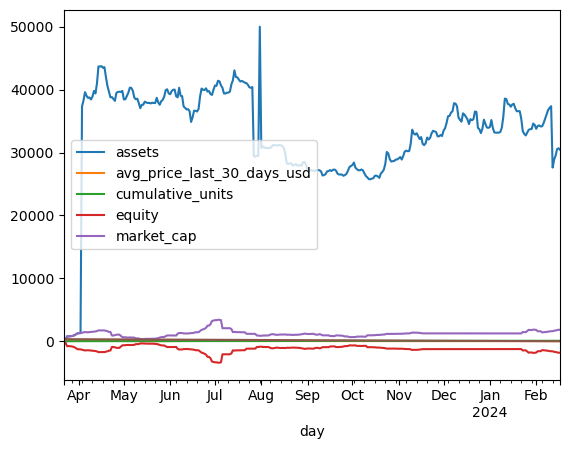

In [129]:
bs_dataframe.plot()

<Axes: xlabel='month'>

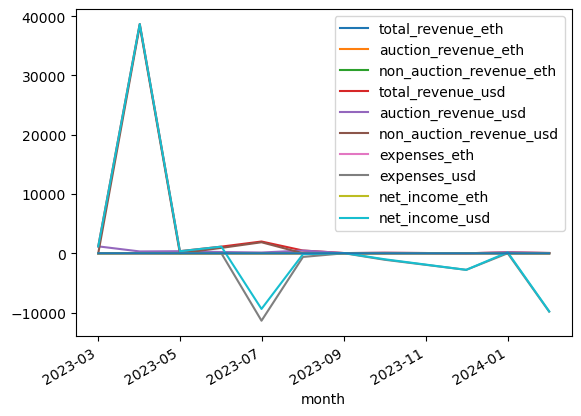

In [130]:
is_dataframe.plot()

In [131]:
def fetch_data_from_api(api_url, params=None):
    response = requests.get(api_url, params=params)
    if response.status_code == 200:
        data = response.json()
        if 'rows' in data['result']:
            return pd.DataFrame(data['result']['rows'])
        return data
    else:
        print(f"Failed to retrieve data: {response.status_code}")
        return pd.DataFrame()  # or an empty dict

In [132]:
api_key_dune = 'w3Tusb5XCOyAMb2ggKHkKuVERuXHnwyW'

In [133]:
lidostaking_url = "https://api.dune.com/api/v1/query/570874/results/"
staking_params = {"api_key": api_key_dune}
staking_timeseries = fetch_data_from_api(lidostaking_url, staking_params)

In [134]:
staking_timeseries['time'] = pd.to_datetime(staking_timeseries['time'])
staking_timeseries.set_index('time', inplace=True)

In [135]:
staking_timeseries

,Lido staking APR(instant),Lido staking APR(ma_30),Lido staking APR(ma_7),protocol APR(ma_7),protocol_apr
time,,,,,
2024-02-16 12:23:23+00:00,3.775849,3.498605,3.601441,4.001601,4.195388
2024-02-15 12:21:59+00:00,3.277571,3.492523,3.616044,4.017826,3.641746
2024-02-14 12:22:11+00:00,3.560068,3.505173,3.689246,4.099162,3.955631
2024-02-13 12:23:11+00:00,4.272868,3.499371,3.672332,4.080368,4.747631
2024-02-12 12:21:59+00:00,3.350554,3.469873,3.536564,3.929515,3.722838
...,...,...,...,...,...
2022-09-05 12:22:07+00:00,3.881250,3.881875,3.881875,4.313194,4.312500
2022-09-04 12:18:25+00:00,3.882292,3.882031,3.882031,4.313368,4.313657
2022-09-03 12:23:50+00:00,3.873958,3.881944,3.881944,4.313272,4.304398


In [136]:
staking = staking_timeseries['Lido staking APR(instant)'].to_frame('APR')

In [137]:
bs_dataframe

,assets,avg_price_last_30_days_usd,cumulative_units,equity,market_cap,__row_index
day,,,,,,
2024-02-17 00:00:00+00:00,30419.115344,24.507603,74,-1813.562622,1813.562622,0
2024-02-16 00:00:00+00:00,30677.273649,24.715592,74,-1828.953808,1828.953808,1
2024-02-15 00:00:00+00:00,30545.190100,24.258520,73,-1770.871960,1770.871960,2
2024-02-14 00:00:00+00:00,29523.124005,23.446811,73,-1711.617191,1711.617191,3
2024-02-13 00:00:00+00:00,28859.561526,22.919820,73,-1673.146840,1673.146840,4
...,...,...,...,...,...,...
2023-03-26 00:00:00+00:00,791.322610,197.830653,4,-791.322610,791.322610,328
2023-03-25 00:00:00+00:00,768.223422,256.074474,3,-768.223422,768.223422,329
2023-03-24 00:00:00+00:00,782.656985,260.885662,3,-782.656985,782.656985,330


In [138]:
staking

,APR
time,
2024-02-16 12:23:23+00:00,3.775849
2024-02-15 12:21:59+00:00,3.277571
2024-02-14 12:22:11+00:00,3.560068
2024-02-13 12:23:11+00:00,4.272868
2024-02-12 12:21:59+00:00,3.350554
...,...
2022-09-05 12:22:07+00:00,3.881250
2022-09-04 12:18:25+00:00,3.882292
2022-09-03 12:23:50+00:00,3.873958


In [139]:
bs_dataframe.index = bs_dataframe.index.normalize()


In [140]:
staking.index = staking.index.normalize()


In [141]:
merged_df = pd.merge(bs_dataframe, staking, left_index=True, right_index=True, how='inner')


In [142]:
merged_df = merged_df.iloc[::-1]

In [143]:
merged_df['APR_daily'] = merged_df['APR'] / 100 / 365
merged_df['APR_Decimal'] = merged_df['APR'] / 100

In [144]:
# Parameters
x_percent = 50 / 100  # 50%

In [145]:
merged_df['staked_ETH'] = merged_df['assets'] * x_percent


In [146]:
merged_df['simple_interest_daily'] = merged_df['staked_ETH'] * merged_df['APR_daily']
merged_df['simple_interest_accumulated'] = merged_df['simple_interest_daily'].cumsum()

In [147]:
merged_df

,assets,avg_price_last_30_days_usd,cumulative_units,equity,market_cap,__row_index,APR,APR_daily,APR_Decimal,staked_ETH,simple_interest_daily,simple_interest_accumulated
2023-03-22 00:00:00+00:00,179.438208,179.438208,1,-179.438208,179.438208,332,4.277083,0.000117,0.042771,89.719104,0.010513,0.010513
2023-03-23 00:00:00+00:00,249.851758,124.925879,2,-249.851758,249.851758,331,4.661458,0.000128,0.046615,124.925879,0.015954,0.026468
2023-03-24 00:00:00+00:00,782.656985,260.885662,3,-782.656985,782.656985,330,4.589583,0.000126,0.045896,391.328493,0.049206,0.075674
2023-03-25 00:00:00+00:00,768.223422,256.074474,3,-768.223422,768.223422,329,4.183333,0.000115,0.041833,384.111711,0.044024,0.119698
2023-03-26 00:00:00+00:00,791.322610,197.830653,4,-791.322610,791.322610,328,4.130208,0.000113,0.041302,395.661305,0.044772,0.164470
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-12 00:00:00+00:00,27611.817075,21.928880,73,-1600.808260,1600.808260,5,3.350554,0.000092,0.033506,13805.908538,1.267327,606.277785
2024-02-13 00:00:00+00:00,28859.561526,22.919820,73,-1673.146840,1673.146840,4,4.272868,0.000117,0.042729,14429.780763,1.689221,607.967005
2024-02-14 00:00:00+00:00,29523.124005,23.446811,73,-1711.617191,1711.617191,3,3.560068,0.000098,0.035601,14761.562002,1.439785,609.406791
2024-02-15 00:00:00+00:00,30545.190100,24.258520,73,-1770.871960,1770.871960,2,3.277571,0.000090,0.032776,15272.595050,1.371425,610.778216


In [148]:


# Assuming merged_df is your DataFrame

# Initialize compound interest for the first day with staked ETH
merged_df['compound_interest'] = merged_df['staked_ETH'].iloc[0]

# Loop through each day to calculate compound interest
for i in range(1, len(merged_df)):
    # Calculate the increase in staked_ETH from the previous day, if any
    daily_increase = merged_df['staked_ETH'].iloc[i] - merged_df['staked_ETH'].iloc[i-1]
    
    # Calculate new principal for the day
    new_principal = merged_df['compound_interest'].iloc[i-1] + daily_increase
    
    # Calculate today's compound interest
    daily_rate = merged_df['APR_daily'].iloc[i]
    merged_df.at[merged_df.index[i], 'compound_interest'] = new_principal * (1 + daily_rate)

# Calculate total compound interest by subtracting the initial staked ETH from the compound interest for each day
merged_df['total_compound_interest'] = merged_df['compound_interest'] - merged_df['staked_ETH']


In [149]:
merged_df['compound_interest_daily'] = merged_df['total_compound_interest'].diff().fillna(0)

In [150]:
# Calculate the return on compound interest in absolute terms
merged_df['absolute_compound_return'] = merged_df['compound_interest'] - merged_df['staked_ETH']

# Calculate the return on compound interest as a percentage of the original staked_ETH
merged_df['compound_return_percentage'] = (merged_df['absolute_compound_return'] / merged_df['staked_ETH']) * 100

# Display the updated DataFrame (or a portion of it for clarity)
merged_df[['staked_ETH', 'compound_interest', 'absolute_compound_return', 'compound_return_percentage']].iloc[::-1]


,staked_ETH,compound_interest,absolute_compound_return,compound_return_percentage
2024-02-16 00:00:00+00:00,15338.636825,15962.381270,623.744445,4.066492
2024-02-15 00:00:00+00:00,15272.595050,15894.688391,622.093341,4.073265
2024-02-14 00:00:00+00:00,14761.562002,15382.228184,620.666182,4.204610
2024-02-13 00:00:00+00:00,14429.780763,15048.946768,619.166005,4.290890
2024-02-12 00:00:00+00:00,13805.908538,14423.313046,617.404509,4.472031
...,...,...,...,...
2023-03-26 00:00:00+00:00,395.661305,395.815283,0.153978,0.038917
2023-03-25 00:00:00+00:00,384.111711,384.220905,0.109194,0.028428
2023-03-24 00:00:00+00:00,391.328493,391.393656,0.065163,0.016652
2023-03-23 00:00:00+00:00,124.925879,124.941834,0.015954,0.012771


<Axes: >

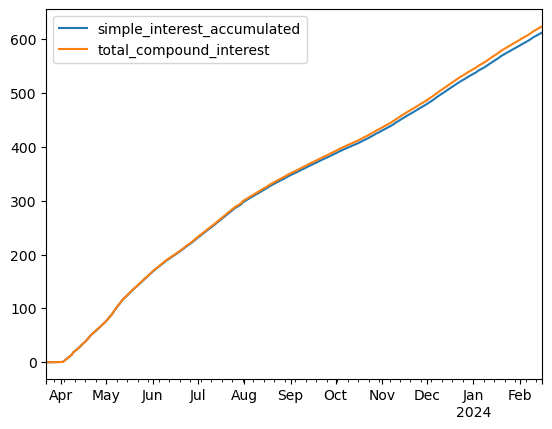

In [151]:
merged_df[['simple_interest_accumulated', 'total_compound_interest']].plot()

In [152]:
merged_df

,assets,avg_price_last_30_days_usd,cumulative_units,equity,market_cap,__row_index,APR,APR_daily,APR_Decimal,staked_ETH,simple_interest_daily,simple_interest_accumulated,compound_interest,total_compound_interest,compound_interest_daily,absolute_compound_return,compound_return_percentage
2023-03-22 00:00:00+00:00,179.438208,179.438208,1,-179.438208,179.438208,332,4.277083,0.000117,0.042771,89.719104,0.010513,0.010513,89.719104,0.000000,0.000000,0.000000,0.000000
2023-03-23 00:00:00+00:00,249.851758,124.925879,2,-249.851758,249.851758,331,4.661458,0.000128,0.046615,124.925879,0.015954,0.026468,124.941834,0.015954,0.015954,0.015954,0.012771
2023-03-24 00:00:00+00:00,782.656985,260.885662,3,-782.656985,782.656985,330,4.589583,0.000126,0.045896,391.328493,0.049206,0.075674,391.393656,0.065163,0.049208,0.065163,0.016652
2023-03-25 00:00:00+00:00,768.223422,256.074474,3,-768.223422,768.223422,329,4.183333,0.000115,0.041833,384.111711,0.044024,0.119698,384.220905,0.109194,0.044031,0.109194,0.028428
2023-03-26 00:00:00+00:00,791.322610,197.830653,4,-791.322610,791.322610,328,4.130208,0.000113,0.041302,395.661305,0.044772,0.164470,395.815283,0.153978,0.044784,0.153978,0.038917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-12 00:00:00+00:00,27611.817075,21.928880,73,-1600.808260,1600.808260,5,3.350554,0.000092,0.033506,13805.908538,1.267327,606.277785,14423.313046,617.404509,1.323881,617.404509,4.472031
2024-02-13 00:00:00+00:00,28859.561526,22.919820,73,-1673.146840,1673.146840,4,4.272868,0.000117,0.042729,14429.780763,1.689221,607.967005,15048.946768,619.166005,1.761497,619.166005,4.290890
2024-02-14 00:00:00+00:00,29523.124005,23.446811,73,-1711.617191,1711.617191,3,3.560068,0.000098,0.035601,14761.562002,1.439785,609.406791,15382.228184,620.666182,1.500176,620.666182,4.204610
2024-02-15 00:00:00+00:00,30545.190100,24.258520,73,-1770.871960,1770.871960,2,3.277571,0.000090,0.032776,15272.595050,1.371425,610.778216,15894.688391,622.093341,1.427159,622.093341,4.073265


In [153]:
cumulative_compound_interest = merged_df['total_compound_interest'].iloc[-1]
cumulative_simple_interest = merged_df['simple_interest_accumulated'].iloc[-1]

In [154]:
cumulative_simple_interest

612.3649661611429

In [155]:
cumulative_compound_interest

623.7444452778072

In [156]:
sim_balance_sheet = merged_df.copy()
sim_balance_sheet['simulated_assets_simple_interest'] = sim_balance_sheet['assets'] + sim_balance_sheet['simple_interest_daily']
sim_balance_sheet['simulated_assets_compound_interest'] = sim_balance_sheet['assets'] + sim_balance_sheet['compound_interest_daily']

In [157]:
sim_balance_sheet[['assets','simulated_assets_simple_interest','simulated_assets_compound_interest']]

,assets,simulated_assets_simple_interest,simulated_assets_compound_interest
2023-03-22 00:00:00+00:00,179.438208,179.448722,179.438208
2023-03-23 00:00:00+00:00,249.851758,249.867713,249.867713
2023-03-24 00:00:00+00:00,782.656985,782.706192,782.706194
2023-03-25 00:00:00+00:00,768.223422,768.267445,768.267453
2023-03-26 00:00:00+00:00,791.322610,791.367382,791.367394
...,...,...,...
2024-02-12 00:00:00+00:00,27611.817075,27613.084402,27613.140956
2024-02-13 00:00:00+00:00,28859.561526,28861.250746,28861.323023
2024-02-14 00:00:00+00:00,29523.124005,29524.563790,29524.624181
2024-02-15 00:00:00+00:00,30545.190100,30546.561525,30546.617258


In [158]:
monthly_yield = merged_df[['simple_interest_daily','compound_interest_daily']].resample('M').sum()

monthly_yield.index = monthly_yield.index.normalize()

In [159]:
monthly_yield

,simple_interest_daily,compound_interest_daily
2023-03-31 00:00:00+00:00,0.483275,0.472955
2023-04-30 00:00:00+00:00,73.267215,73.397847
2023-05-31 00:00:00+00:00,91.997681,92.564260
2023-06-30 00:00:00+00:00,62.996668,63.641862
2023-07-31 00:00:00+00:00,68.090122,68.993676
2023-08-31 00:00:00+00:00,49.267554,50.344817
2023-09-30 00:00:00+00:00,40.325448,41.430564
2023-10-31 00:00:00+00:00,42.158998,43.424168
2023-11-30 00:00:00+00:00,49.262902,50.683053
2023-12-31 00:00:00+00:00,56.106976,57.736937


In [160]:
is_dataframe.index = is_dataframe.index.normalize()

In [161]:
is_dataframe_monthly = is_dataframe.resample('M').sum()
is_dataframe_monthly

,total_revenue_eth,auction_revenue_eth,non_auction_revenue_eth,total_revenue_usd,auction_revenue_usd,non_auction_revenue_usd,expenses_eth,expenses_usd,net_income_eth,net_income_usd,__row_index
month,,,,,,,,,,,
2023-03-31 00:00:00+00:00,0.69530,0.69530,1.110223e-16,1164.823540,1164.823540,1.859937e-13,0.00,0.000000,0.69530,1164.823540,10
2023-04-30 00:00:00+00:00,20.16130,0.16130,2.000000e+01,38680.772655,309.464599,3.837131e+04,0.00,0.000000,20.16130,38680.772655,9
2023-05-31 00:00:00+00:00,0.19020,0.19020,0.000000e+00,350.509119,350.509119,0.000000e+00,0.00,0.000000,0.19020,350.509119,8
2023-06-30 00:00:00+00:00,0.61630,0.11630,5.000000e-01,1120.464908,211.439346,9.090256e+02,0.00,0.000000,0.61630,1120.464908,7
2023-07-31 00:00:00+00:00,1.04700,0.06700,9.800000e-01,1984.660337,127.003097,1.857657e+03,-6.00,-11373.411674,-4.95300,-9388.751337,6
2023-08-31 00:00:00+00:00,0.26356,0.26356,-5.551115e-17,463.757264,463.757264,-9.767681e-14,-0.35,-615.856133,-0.08644,-152.098869,5
2023-09-30 00:00:00+00:00,0.02000,0.02000,0.000000e+00,32.419436,32.419436,0.000000e+00,0.00,0.000000,0.02000,32.419436,4
2023-10-31 00:00:00+00:00,0.05100,0.05100,0.000000e+00,84.453608,84.453608,0.000000e+00,-0.66,-1092.929049,-0.60900,-1008.475441,3
2023-11-30 00:00:00+00:00,0.00000,0.00000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.00,0.000000,0.00000,0.000000,0


In [162]:
income_stmt_sim = is_dataframe_monthly[['total_revenue_usd','auction_revenue_usd','expenses_usd','net_income_usd']].merge(monthly_yield, left_index=True, right_index=True)

In [163]:
income_stmt_sim['simulated_rev_simple_interest'] = income_stmt_sim['total_revenue_usd'] + income_stmt_sim['simple_interest_daily']
income_stmt_sim['simulated_rev_compound_interest'] = income_stmt_sim['total_revenue_usd'] + income_stmt_sim['compound_interest_daily']

income_stmt_sim['simple_interest_net_income'] = income_stmt_sim['simulated_rev_simple_interest'] + income_stmt_sim['expenses_usd']
income_stmt_sim['compound_interest_net_income'] = income_stmt_sim['simulated_rev_compound_interest'] + income_stmt_sim['expenses_usd']

In [164]:
income_stmt_sim['simple_interest_income_diff'] = income_stmt_sim['simple_interest_net_income'] - income_stmt_sim['net_income_usd']
income_stmt_sim['compound_interest_income_diff'] = income_stmt_sim['compound_interest_net_income'] - income_stmt_sim['net_income_usd']

In [165]:
income_stmt_sim

,total_revenue_usd,auction_revenue_usd,expenses_usd,net_income_usd,simple_interest_daily,compound_interest_daily,simulated_rev_simple_interest,simulated_rev_compound_interest,simple_interest_net_income,compound_interest_net_income,simple_interest_income_diff,compound_interest_income_diff
month,,,,,,,,,,,,
2023-03-31 00:00:00+00:00,1164.823540,1164.823540,0.000000,1164.823540,0.483275,0.472955,1165.306816,1165.296495,1165.306816,1165.296495,0.483275,0.472955
2023-04-30 00:00:00+00:00,38680.772655,309.464599,0.000000,38680.772655,73.267215,73.397847,38754.039870,38754.170502,38754.039870,38754.170502,73.267215,73.397847
2023-05-31 00:00:00+00:00,350.509119,350.509119,0.000000,350.509119,91.997681,92.564260,442.506800,443.073379,442.506800,443.073379,91.997681,92.564260
2023-06-30 00:00:00+00:00,1120.464908,211.439346,0.000000,1120.464908,62.996668,63.641862,1183.461576,1184.106771,1183.461576,1184.106771,62.996668,63.641862
2023-07-31 00:00:00+00:00,1984.660337,127.003097,-11373.411674,-9388.751337,68.090122,68.993676,2052.750459,2053.654013,-9320.661214,-9319.757661,68.090122,68.993676
2023-08-31 00:00:00+00:00,463.757264,463.757264,-615.856133,-152.098869,49.267554,50.344817,513.024818,514.102081,-102.831315,-101.754052,49.267554,50.344817
2023-09-30 00:00:00+00:00,32.419436,32.419436,0.000000,32.419436,40.325448,41.430564,72.744883,73.850000,72.744883,73.850000,40.325448,41.430564
2023-10-31 00:00:00+00:00,84.453608,84.453608,-1092.929049,-1008.475441,42.158998,43.424168,126.612607,127.877776,-966.316443,-965.051273,42.158998,43.424168
2023-11-30 00:00:00+00:00,0.000000,0.000000,0.000000,0.000000,49.262902,50.683053,49.262902,50.683053,49.262902,50.683053,49.262902,50.683053


In [166]:
income_stmt_sim['net_income_usd_nozero'] = income_stmt_sim['net_income_usd'].replace({0: 1})


income_stmt_sim

,total_revenue_usd,auction_revenue_usd,expenses_usd,net_income_usd,simple_interest_daily,compound_interest_daily,simulated_rev_simple_interest,simulated_rev_compound_interest,simple_interest_net_income,compound_interest_net_income,simple_interest_income_diff,compound_interest_income_diff,net_income_usd_nozero
month,,,,,,,,,,,,,
2023-03-31 00:00:00+00:00,1164.823540,1164.823540,0.000000,1164.823540,0.483275,0.472955,1165.306816,1165.296495,1165.306816,1165.296495,0.483275,0.472955,1164.823540
2023-04-30 00:00:00+00:00,38680.772655,309.464599,0.000000,38680.772655,73.267215,73.397847,38754.039870,38754.170502,38754.039870,38754.170502,73.267215,73.397847,38680.772655
2023-05-31 00:00:00+00:00,350.509119,350.509119,0.000000,350.509119,91.997681,92.564260,442.506800,443.073379,442.506800,443.073379,91.997681,92.564260,350.509119
2023-06-30 00:00:00+00:00,1120.464908,211.439346,0.000000,1120.464908,62.996668,63.641862,1183.461576,1184.106771,1183.461576,1184.106771,62.996668,63.641862,1120.464908
2023-07-31 00:00:00+00:00,1984.660337,127.003097,-11373.411674,-9388.751337,68.090122,68.993676,2052.750459,2053.654013,-9320.661214,-9319.757661,68.090122,68.993676,-9388.751337
2023-08-31 00:00:00+00:00,463.757264,463.757264,-615.856133,-152.098869,49.267554,50.344817,513.024818,514.102081,-102.831315,-101.754052,49.267554,50.344817,-152.098869
2023-09-30 00:00:00+00:00,32.419436,32.419436,0.000000,32.419436,40.325448,41.430564,72.744883,73.850000,72.744883,73.850000,40.325448,41.430564,32.419436
2023-10-31 00:00:00+00:00,84.453608,84.453608,-1092.929049,-1008.475441,42.158998,43.424168,126.612607,127.877776,-966.316443,-965.051273,42.158998,43.424168,-1008.475441
2023-11-30 00:00:00+00:00,0.000000,0.000000,0.000000,0.000000,49.262902,50.683053,49.262902,50.683053,49.262902,50.683053,49.262902,50.683053,1.000000


In [167]:
income_stmt_sim['simple_interest_percent_chg'] = income_stmt_sim['simple_interest_income_diff'] / abs(income_stmt_sim['net_income_usd_nozero'])
income_stmt_sim['compound_interest_percent_chg'] = income_stmt_sim['compound_interest_income_diff'] / abs(income_stmt_sim['net_income_usd_nozero'])

In [168]:
income_stmt_sim[['compound_interest_income_diff','net_income_usd_nozero','compound_interest_percent_chg']]

,compound_interest_income_diff,net_income_usd_nozero,compound_interest_percent_chg
month,,,
2023-03-31 00:00:00+00:00,0.472955,1164.823540,0.000406
2023-04-30 00:00:00+00:00,73.397847,38680.772655,0.001898
2023-05-31 00:00:00+00:00,92.564260,350.509119,0.264085
2023-06-30 00:00:00+00:00,63.641862,1120.464908,0.056800
2023-07-31 00:00:00+00:00,68.993676,-9388.751337,0.007349
2023-08-31 00:00:00+00:00,50.344817,-152.098869,0.331001
2023-09-30 00:00:00+00:00,41.430564,32.419436,1.277955
2023-10-31 00:00:00+00:00,43.424168,-1008.475441,0.043059
2023-11-30 00:00:00+00:00,50.683053,1.000000,50.683053


In [169]:
income_stmt_sim[['simple_interest_percent_chg','compound_interest_percent_chg']]

,simple_interest_percent_chg,compound_interest_percent_chg
month,,
2023-03-31 00:00:00+00:00,0.000415,0.000406
2023-04-30 00:00:00+00:00,0.001894,0.001898
2023-05-31 00:00:00+00:00,0.262469,0.264085
2023-06-30 00:00:00+00:00,0.056224,0.056800
2023-07-31 00:00:00+00:00,0.007252,0.007349
2023-08-31 00:00:00+00:00,0.323918,0.331001
2023-09-30 00:00:00+00:00,1.243866,1.277955
2023-10-31 00:00:00+00:00,0.041805,0.043059
2023-11-30 00:00:00+00:00,49.262902,50.683053


In [170]:
income_stmt_sim['equity_investments_usd'] = income_stmt_sim['total_revenue_usd'] - income_stmt_sim['auction_revenue_usd']

In [171]:
income_stmt_sim = income_stmt_sim.drop(columns=['simple_interest_income_diff'])

In [172]:
income_stmt_sim = income_stmt_sim.drop(columns=['compound_interest_income_diff'])

In [173]:
revenue_sources = income_stmt_sim[['total_revenue_usd','auction_revenue_usd','simple_interest_daily','compound_interest_daily']]

In [174]:
revenue_sources['equity_investments_usd'] = revenue_sources['total_revenue_usd'] - revenue_sources['auction_revenue_usd']

In [175]:
revenue_sources = revenue_sources.drop(columns=['total_revenue_usd'])

In [176]:
cumulative_revenue_sources = revenue_sources.sum()

In [177]:
cumulative_revenue_sources

auction_revenue_usd         2954.826875
simple_interest_daily        612.364966
compound_interest_daily      623.744445
equity_investments_usd     41137.990858
dtype: float64

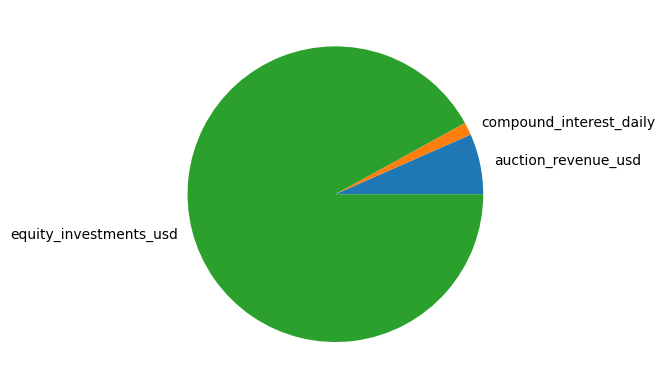

In [178]:
compound_interest_pie = cumulative_revenue_sources[['auction_revenue_usd','compound_interest_daily','equity_investments_usd']].plot.pie()

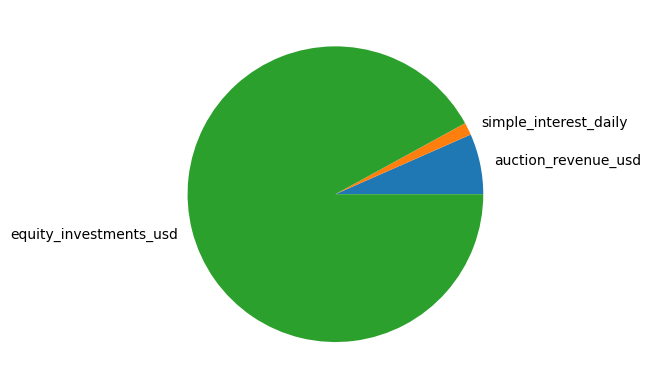

In [179]:
simple_interest_pie = cumulative_revenue_sources[['auction_revenue_usd','simple_interest_daily','equity_investments_usd']].plot.pie()

In [180]:
revenue_sources['auction_revenue_usd'].describe()

count      12.000000
mean      246.235573
std       324.796027
min         0.000000
25%        45.389282
50%       144.123699
75%       319.725729
max      1164.823540
Name: auction_revenue_usd, dtype: float64

In [181]:
revenue_sources['compound_interest_daily'].describe()

count    12.000000
mean     51.978704
std      23.459741
min       0.472955
25%      42.925767
50%      52.545754
75%      64.979816
max      92.564260
Name: compound_interest_daily, dtype: float64

In [182]:
# Assuming 'revenue_sources' is your DataFrame
interest_more_than_auctions = revenue_sources[revenue_sources['simple_interest_daily'] > revenue_sources['auction_revenue_usd']]
 

<Axes: xlabel='month'>

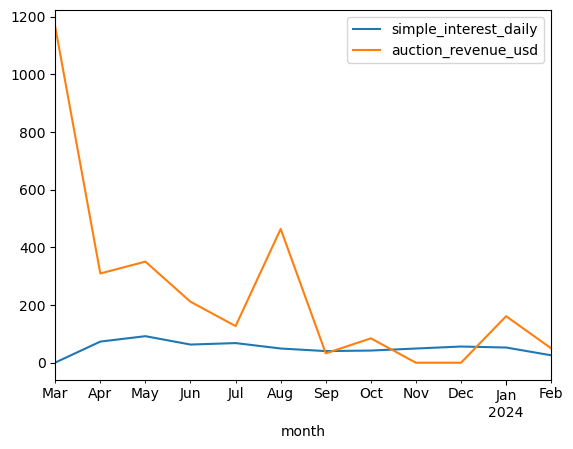

In [183]:
income_stmt_sim[['simple_interest_daily','auction_revenue_usd']].plot()

In [184]:
interest_vs_auctions = px.bar(
    data_frame = income_stmt_sim,
    x = income_stmt_sim.index,
    y = ['auction_revenue_usd', 'simple_interest_daily'],
    barmode = 'relative'
    
)

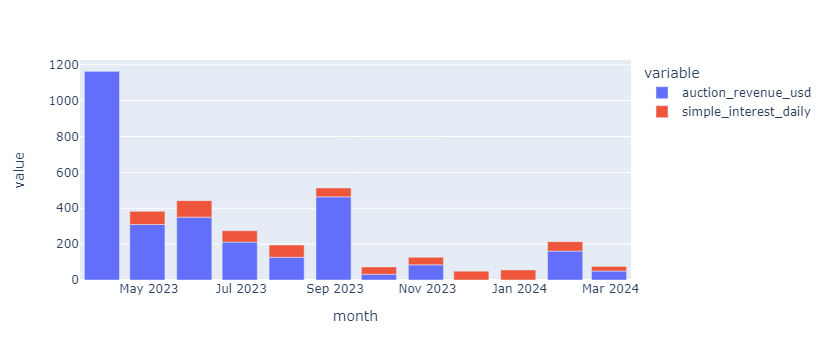

In [185]:
interest_vs_auctions

In [186]:
net_income_comparison = income_stmt_sim[['net_income_usd','simple_interest_net_income','simple_interest_percent_chg']]

In [187]:
income_pct_chg = px.bar(
    data_frame = net_income_comparison,
    x = income_stmt_sim.index,
    y = ['simple_interest_percent_chg']
   
    
)

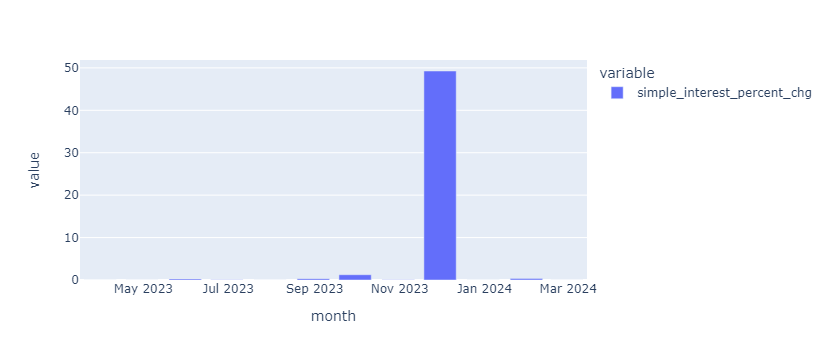

In [188]:
income_pct_chg

In [189]:
#Shows how much net income increases from adding staking yield; in months with 0 income, the staking yield results in high % increase
#75% of time, staking yield boosts income by 43% or lower

net_income_comparison['simple_interest_percent_chg'].describe()

count    12.000000
mean      4.295857
std      14.165304
min       0.000415
25%       0.006095
50%       0.049014
75%       0.324648
max      49.262902
Name: simple_interest_percent_chg, dtype: float64

In [190]:
#Can expect average of $50 per month from staking
#25th percentile for interest is higher than auction revenue 25th percentile
income_stmt_sim['simple_interest_daily'].describe()

count    12.000000
mean     51.030414
std      23.415954
min       0.483275
25%      41.700611
50%      50.984130
75%      64.270032
max      91.997681
Name: simple_interest_daily, dtype: float64

In [191]:
#Half of auction revenues per month are under $144
income_stmt_sim['auction_revenue_usd'].describe()

count      12.000000
mean      246.235573
std       324.796027
min         0.000000
25%        45.389282
50%       144.123699
75%       319.725729
max      1164.823540
Name: auction_revenue_usd, dtype: float64

<Axes: ylabel='Frequency'>

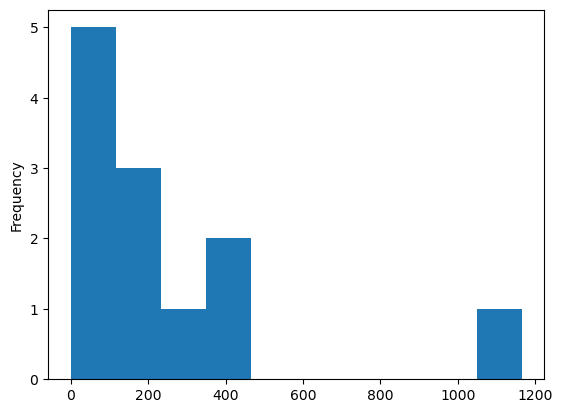

In [192]:
revenue_sources['auction_revenue_usd'].plot.hist()
#monthly_revenue from auctions usually under $500

In [193]:
#3 months where staking revenue was larger than auction revenue

interest_more_than_auctions

,auction_revenue_usd,simple_interest_daily,compound_interest_daily,equity_investments_usd
month,,,,
2023-09-30 00:00:00+00:00,32.419436,40.325448,41.430564,0.0
2023-11-30 00:00:00+00:00,0.000000,49.262902,50.683053,0.0
2023-12-31 00:00:00+00:00,0.000000,56.106976,57.736937,0.0


In [194]:
income_stmt_sim['simple_interest_percent_chg'].describe()

count    12.000000
mean      4.295857
std      14.165304
min       0.000415
25%       0.006095
50%       0.049014
75%       0.324648
max      49.262902
Name: simple_interest_percent_chg, dtype: float64